In [1]:
using PyPlot
using Roots
using NLsolve
using DataFrames
using IMinuit

In [2]:
include("./src/lattice_data.jl")
include("./src/latt_para.jl")
include("./src/tmat_finite_vol.jl")
include("./src/tmat_finite_vol_nlo.jl")

LoadError: LoadError: syntax: unexpected "end"
in expression starting at /Users/zejian/Documents/works_in_ific/lam1405_10_08_2023/energy_level_julia/src/tmat_finite_vol.jl:60

In [6]:
latt_para = lattice_params()

Dict{Symbol, Any} with 5 entries:
  :m_meson    => (203.655, 486.366)
  :threshold  => [1397.59, 1466.14, 1683.94, 1781.53]
  :decons_vec => [93.1531, 108.23, 119.217, 108.23]
  :L          => 0.0205243
  :mch        => [(203.655, 1193.94), (486.366, 979.777), (551.1, 1132.84), (48…

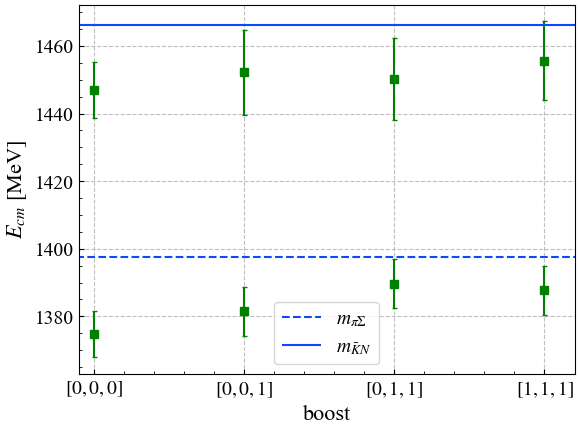

In [7]:
fig, ax = PyPlot.subplots()
plot_latt_ener_2level!(ax, _2lv, _2lv_err, latt_para[:threshold] )
ax.grid()
gcf()

In [8]:
params = copy(latt_para)
f = 1.1999999988821624
fπ = 93

#params[:decons_vec] = [fπ fπ*f; fπ*f fπ]#[92.4, 92.4, 92.4, 92.4] .* 1.2
params[:decons_vec] = [fπ, 108e0]

2-element Vector{Float64}:
  93.0
 108.0

In [9]:
function cost_fun!(latt_pole, latt_pole_err, params, Nv, fitted_para; dof=2,  fix_f=false)
    para = copy(params)
    if fix_f == true
        a1, a2, f, fπ = fitted_para
        
        para[:decons_vec] = [fπ fπ*f; fπ*f fπ]
    else
        a1, a2 = fitted_para
    end

    dd = 0e0
    len = 0e0
    for (pole, pole_err, N) in zip(latt_pole, latt_pole_err, Nv)
        p = []
        df1 = bisection_internal_sol!(x -> tdet_finite_vol_params!(x, para, [a1, a2], N), 1350, 1400, 1)
        df2 = bisection_internal_sol!(x -> tdet_finite_vol_params!(x, para, [a1, a2], N), 1420, 1468, 1)
        x10 = df1.x0
        x20 = df2.x0

        if length(x10) == 1
            append!(p, x10)
        else
            append!(p, pole_finite_vol!(1380, para, [a1, a2], N))
        end
        
        if length(x20) == 1
            append!(p, x20)
        else
            append!(p, pole_finite_vol!(1466, para, [a1, a2], N) )
        end
        
        d = (pole - p) ./ pole_err
        dd += d' * d
        len += length(pole)
    end
    return dd / (len - dof)
end

Nv = [[0,0,0], [0,0,1],[0,1,1],[1,1,1]]

function makefit_finite_lo!(costfun, init_para)
    m = Minuit(costfun, init_para, limit_x0=(-5, -0.1), limit_x1=(-5, -0.1))
    m.strategy = 2
    migrad(m)
    migrad(m)
end

#m = makefit_finite_lo!(f -> cost_fun!(_2lv, _2lv_err, params, Nv, f), [-1.6325762046840782, -1.7138485812778343])

makefit_finite_lo! (generic function with 1 method)

In [10]:
#a_fit = [m.values...]
 a_fit = [-1.6325807018101615, -1.7138494070912544]

2-element Vector{Float64}:
 -1.6325807018101615
 -1.7138494070912544

  1.263788 seconds (14.23 M allocations: 589.124 MiB, 5.89% gc time, 83.27% compilation time)


  0.454063 seconds (23.83 M allocations: 671.493 MiB, 11.56% gc time, 4.44% compilation time)


  0.425254 seconds (23.82 M allocations: 667.350 MiB, 10.34% gc time)


  0.422556 seconds (23.93 M allocations: 669.711 MiB, 9.69% gc time)


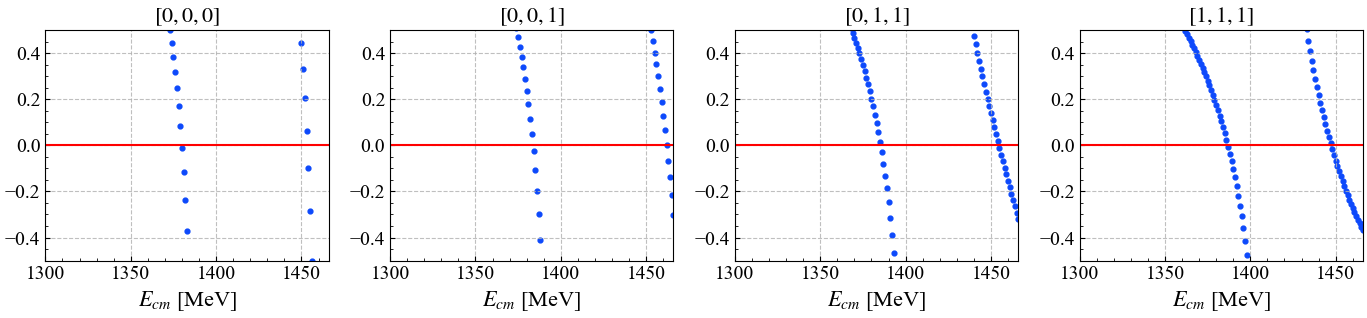

In [11]:
w = 1300:1:1466
fig, ax = PyPlot.subplots(1, 4, figsize=(14, 3.5), tight_layout=true)
title = [L"$[0,0,0]$", L"$[0,0,1]$", L"$[0,1,1]$", L"$[1,1,1]$"]
for (i, G) in enumerate([[0,0,0], [0,0,1],[0,1,1],[1,1,1]] )
    ax[i].set_title(title[i])
    @time plot_tdet_finite_vol!(ax[i], w, params, a_fit, G)
end
gcf()

In [12]:
@time bisection_internal_sol!(x -> tdet_finite_vol_params!(x, params, a_fit, [0, 1, 1]), 1350, 1466, 1)

  4.046787 seconds (57.89 M allocations: 1.977 GiB, 7.58% gc time, 77.67% compilation time)


Row,bis_inter,bis_x0,x0
,Any,Any,Any
1,"(1385, 1386)",1385.32,1385.32
2,"(1454, 1455)",1454.62,1454.62


In [37]:
function pole_finite_LO_2lv_bisection!(params, a, Nv)
    p = DataFrame([])
    columns = ["[0, 0, 0]", "[0, 0, 1]", "[0,1,1]", "[1,1,1]"]

    for (i, N) in enumerate(Nv)
        df = bisection_internal_sol!(x -> tdet_finite_vol_params!(x, params, a, N), 1350, 1470, 1)
        x0 = df.x0
        p[!, columns[i] ] = x0
    end
    #pp = DataFrame(p, ["[0,0,0]", "[0,0,1]", "[0,1,1]", "[1,1,1]"])
    return p
end
df = pole_finite_LO_2lv_bisection!(params, a_fit, Nv)
pole = [df[1:2, i] for i in 1:4]
df

Row,"[0, 0, 0]","[0, 0, 1]","[0,1,1]","[1,1,1]"
,Any,Any,Any,Any
1,1379.89,1383.65,1385.32,1386.8
2,1453.41,1462.04,1454.62,1447.35


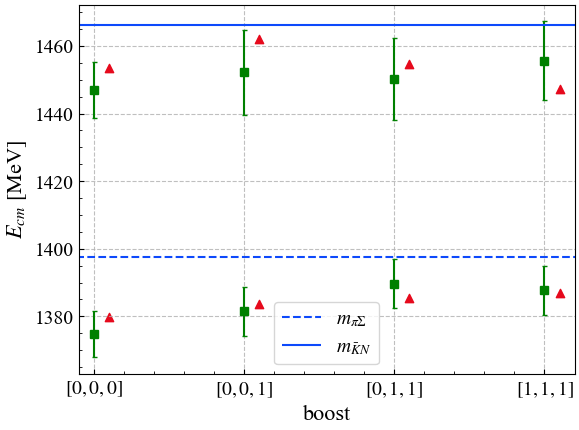

In [51]:
fig, ax = PyPlot.subplots()
plot_theory_ener_2level!(ax, pole)
plot_latt_ener_2level!(ax, _2lv, _2lv_err, latt_para[:threshold] )
ax.grid()
fig.savefig("./figure/two_energy_level_fitted.pdf")
gcf()

In [16]:
b = Dict(
    :b0 => -0.6208300893256031e-3,
    :bD => 0.0603969112334734e-3,
    :bF => -0.3479468364318576e-3
) 

Dict{Symbol, Float64} with 3 entries:
  :bD => 6.03969e-5
  :bF => -0.000347947
  :b0 => -0.00062083

In [17]:
params

Dict{Symbol, Any} with 5 entries:
  :m_meson    => (203.655, 486.366)
  :threshold  => [1397.59, 1466.14, 1683.94, 1781.53]
  :decons_vec => [93.0, 108.0]
  :L          => 0.0205243
  :mch        => [(203.655, 1193.94), (486.366, 979.777), (551.1, 1132.84), (48…

In [18]:
dv = [-0.36e-3, 0.09e-3, 0.1e-3, -0.19e-3]

4-element Vector{Float64}:
 -0.00036
  9.0e-5
  0.0001
 -0.00019

  1.598624 seconds (48.16 M allocations: 1.601 GiB, 11.87% gc time, 42.01% compilation time)


  1.979544 seconds (106.87 M allocations: 2.927 GiB, 14.74% gc time)


  1.894820 seconds (107.16 M allocations: 2.933 GiB, 14.29% gc time)


  1.895001 seconds (107.65 M allocations: 2.944 GiB, 14.09% gc time)


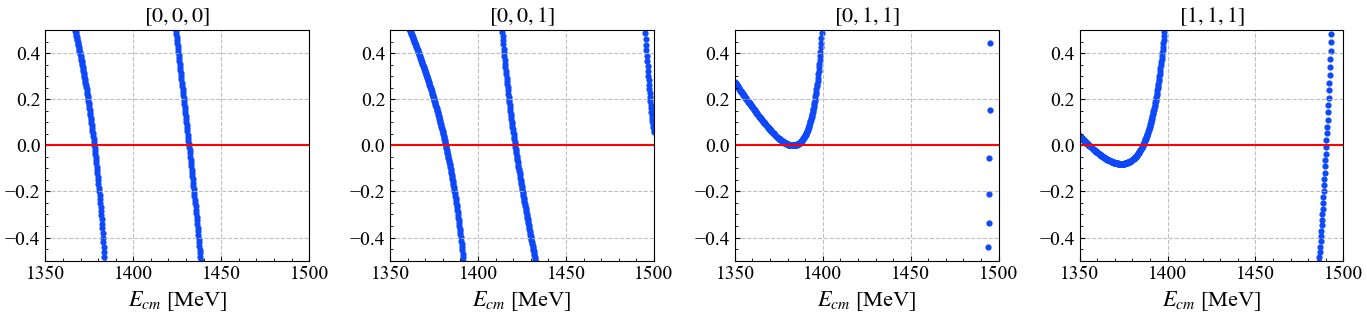

In [19]:
#b = Dict(:b0 => -0.43e-3, :bD => 0.08e-3, :bF => -0.27e-3)
d = Dict(:d1 => -0.36e-3, :d2 => 0.09e-3, :d3 => 0.1e-3, :d4 => -0.19e-3)

w = 1350:0.2:1500
fig, ax = PyPlot.subplots(1, 4, figsize=(14, 3.5), tight_layout=true)
title = [L"$[0,0,0]$", L"$[0,0,1]$", L"$[0,1,1]$", L"$[1,1,1]$"]
for (i, G) in enumerate([[0,0,0], [0,0,1],[0,1,1],[1,1,1]] )
    ax[i].set_title(title[i])
    @time plot_tdet_finite_vol_nlo!(ax[i], w, params, [-1.6000000046383431,
    -2.1632662671478324], b, d, G)
    
end
gcf()

In [20]:
d = Dict(:d1 => -0.0007200347775540628,
:d2 => 9.529993667344445e-5,
:d3 => 0.00010004393304491052,
:d4 => -0.00018999999902333676)

Dict{Symbol, Float64} with 4 entries:
  :d4 => -0.00019
  :d2 => 9.52999e-5
  :d1 => -0.000720035
  :d3 => 0.000100044

In [21]:
df  = bisection_internal_sol_nlo!(x -> tdet_finite_vol_nlo_params!(x, params, [-1.6000000046383431,
-2.1632662671478324], b, d, [1, 1, 1]), 1300, 1500, 1)

Row,bis_inter,bis_x0,x0
,Any,Any,Any
1,"(1366, 1367)",1366.85,1366.85
2,"(1386, 1387)",1386.03,1386.03
3,"(1490, 1491)",1490.38,1490.38


In [22]:
df.x0[1:2]

2-element Vector{Any}:
 1366.848705291748
 1386.027416229248

In [23]:
Nv = [[0,0,0], [0,0,1],[0,1,1],[1,1,1]]

4-element Vector{Vector{Int64}}:
 [0, 0, 0]
 [0, 0, 1]
 [0, 1, 1]
 [1, 1, 1]

In [24]:
_2lv

4-element Vector{Vector{Float64}}:
 [1374.6723273675, 1446.9214197053334]
 [1381.4608326878333, 1452.2552453141668]
 [1389.7040177196668, 1450.3156723655002]
 [1387.764444771, 1455.6494979743334]

In [25]:
dv

4-element Vector{Float64}:
 -0.00036
  9.0e-5
  0.0001
 -0.00019

In [26]:
_2lv_err

4-element Vector{Vector{Float64}}:
 [6.788505320333343, 8.243185031833264]
 [7.273398557500059, 12.607224166333253]
 [7.273398557499831, 12.122330929166537]
 [7.273398557500059, 11.637437692000049]

In [27]:
Dict(:d1 => dv[1])

Dict{Symbol, Float64} with 1 entry:
  :d1 => -0.00036

In [29]:
using SciPy

In [31]:
L = params[:L]
mch = params[:mch]
decons = params[:decons_vec]
m_meson = params[:m_meson]

(203.65515961, 486.36580442)

In [32]:
function cost_fun_nlo!(latt_pole, latt_pole_err, params, Nv, a, b, fitted_d)
    mch = params[:mch]
    m_meson = params[:m_meson]
    L = params[:L]
    decons = params[:decons_vec]
    d = Dict(:d1 => fitted_d[1], :d2 => fitted_d[2], :d3 => fitted_d[3], :d4 => fitted_d[4] )
    ddd = 0e0
    len = 0e0
    for (pole, pole_err, N) in zip(latt_pole, latt_pole_err, Nv)
        #df = bisection_internal_sol_nlo!(x -> tdet_finite_vol_nlo!(x, mch, decons, m_meson, L, a, b, d, N), 1300, 1550, 1)
        p = []
        append!(p, [pole_finite_vol_nlo!(pole[i], mch, decons, m_meson, L, a, b, d, N) for i in 1:2])
        dd = (pole - p) ./ pole_err
        ddd += dd' * dd
        len += length(pole)
    end
    return ddd / (len - 4)
end

#cost_fun_nlo!(_2lv, _2lv_err, Nv, a2, b, dv)
#res = SciPy.optimize.minimize(dv -> cost_fun_nlo!(_2lv, _2lv_err, params, Nv, dv[1:2], b, dv[3:]), [-1.6, -2.2, -0.36e-3, 0.09e-3, 0.1e-3, -0.19e-3])

cost_fun_nlo! (generic function with 1 method)

In [33]:
#mm = minuit.Minuit(dv -> cost_fun_nlo!(_2lv, _2lv_err, params, Nv, dv[1:2], b, dv[3:end]), [-1.6, -2.2, -0.36e-3, 0.09e-3, 0.1e-3, -0.19e-3])
#mm.migrad()

In [34]:
#[mm.values...]